# Part 3 - Simple Analysis

In this step, we perform the first simple analysis of the taxi trip data in order to get a better understanding.

# 0. Setup Environment

## 0.1 Spark Session

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

if not 'spark' in locals():
    spark = SparkSession.builder \
        .master("local[*]") \
        .config("spark.driver.memory","64G") \
        .getOrCreate()

spark

## 0.2 Matplotlib

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## 0.3 Geopandas and friends

In [3]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

# Helper function to fetch background map tiles
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

# 1. Read Taxi Data

Now we can read in the taxi data from the structured zone.

In [4]:
taxi_trips = spark.read.table("refined.taxi_trip")
taxi_trips.limit(10).toPandas()

,medallion,hack_license,vendor_id,pickup_datetime,rate_code,store_and_fwd_flag,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,00005007A9F30E289E760362F69E4EAD,0938A8DBC34197F8F91F700E3015A7A2,CMT,2013-07-16 09:21:09,1,N,2013-07-16 09:30:51,1,582,1.6,...,40.779961,-73.971527,40.758743,CRD,8.5,0.0,0.5,3.00,0.00,12.00
1,00005007A9F30E289E760362F69E4EAD,0FD461760B482C0B229B3E98A2914819,CMT,2013-10-27 23:40:08,1,N,2013-10-27 23:44:37,2,268,1.1,...,40.751877,-73.990974,40.750546,CRD,5.5,0.5,0.5,1.30,0.00,7.80
2,00005007A9F30E289E760362F69E4EAD,16780B3E72BAA7A5C152C197919DCA0E,CMT,2013-07-16 19:55:27,1,N,2013-07-16 20:17:49,1,1341,5.6,...,40.756721,-73.992645,40.693542,CRD,19.5,1.0,0.5,4.20,0.00,25.20
3,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-10-08 08:37:48,1,N,2013-10-08 08:51:42,2,833,1.9,...,40.786240,-73.957230,40.782959,CRD,11.0,0.0,0.5,3.00,0.00,14.50
4,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-10-18 13:49:19,1,N,2013-10-18 14:15:40,1,1580,3.1,...,40.750698,-73.956955,40.780392,CSH,18.0,0.0,0.5,0.00,0.00,18.50
5,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-10-28 13:39:04,1,N,2013-10-28 13:58:48,1,1184,1.8,...,40.764244,-73.994011,40.742683,CRD,13.5,0.0,0.5,2.80,0.00,16.80
6,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-10-30 08:27:05,1,N,2013-10-30 08:37:00,2,595,1.5,...,40.763229,-73.985291,40.747501,CSH,8.5,0.0,0.5,0.00,0.00,9.00
7,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-11-06 07:42:33,1,N,2013-11-06 07:57:27,1,893,3.9,...,40.755318,-74.013184,40.715298,CRD,14.0,0.0,0.5,2.90,0.00,17.40
8,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-11-15 11:41:42,1,N,2013-11-15 11:49:49,1,487,1.2,...,40.758041,-73.985641,40.746239,CSH,7.5,0.0,0.5,0.00,0.00,8.00
9,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-12-09 06:22:15,1,N,2013-12-09 06:39:43,1,1048,8.4,...,40.748840,-73.870552,40.773499,CRD,24.5,0.0,0.5,6.06,5.33,36.39


Just to be sure, let us inspect the schema. It should match exactly the specified one.

In [5]:
taxi_trips.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- surcharge: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)



## 1.3 Create Sample

For some actions, we only need a subset of the whole data (some visualizations won't event work with the full data), therefore we create a subsample that is small enough to be handeled efficiently by Python. We'd like to have around 100,000 records in the sample.

Spark offers the required functionality to create a *random* sample of the data, but we need to specify a fraction instead of an absolute number. Therefore we first count the number of records and then make up an appropriate fraction.

In [6]:
taxi_trips.count()

173185091

In order to get around 100,000 records, we use a fraction of 0.001. This will give us 170,000 records, which is good enough for us.

In [7]:
taxi_trips_sample = taxi_trips \
    .sample(0.001) \
    .cache()

taxi_trips_sample.count()

173463

# 2. Simple Geo Visualisation

In order to get an understanding of the data, let us first make a geo visualization using some Python functionality. We'd eventually want to draw the pickup locations on top of a map, so we understand the whole area that is served by the taxi cabs. We might want to use this information later when it comes to the ML part.

## 2.1 Estimate Extent

As a first step, let us estimate a realistic extent of the pickup location. There are some broken records in the data set, which would render the visualisation meaningless, therefore we try to estimate extends such that 95% of all points lie within that border.

In [8]:
quantile = taxi_trips_sample \
    .filter((taxi_trips_sample["pickup_longitude"] > -75) & (taxi_trips_sample["pickup_longitude"] < -65)) \
    .filter((taxi_trips_sample["pickup_latitude"] > 35) & (taxi_trips_sample["pickup_latitude"] < 45)) \
    .stat.approxQuantile(["pickup_longitude", "pickup_latitude"], [0.025,0.975], 0.01)

min_pickup_longitude = quantile[0][0]
max_pickup_longitude = quantile[0][1]
min_pickup_latitude = quantile[1][0]
max_pickup_latitude = quantile[1][1]

print("min_pickup_longitude=" + str(min_pickup_longitude))
print("max_pickup_longitude=" + str(max_pickup_longitude))
print("min_pickup_latitude=" + str(min_pickup_latitude))
print("max_pickup_latitude=" + str(max_pickup_latitude))

min_pickup_longitude=-74.007072
max_pickup_longitude=-73.776672
min_pickup_latitude=40.709442
max_pickup_latitude=40.871254


## 2.2 Visualize pickup location

Now by using some appropriate Python libraries, we can visualize the pickup locations nicely on a map.

Since the data contains some bogus coordinates and some (maybe correct) outliers, we limit the area to the extends that we estimated above. This means that we throw away all records which lie outside of the core area (only for this visualization, of course!)

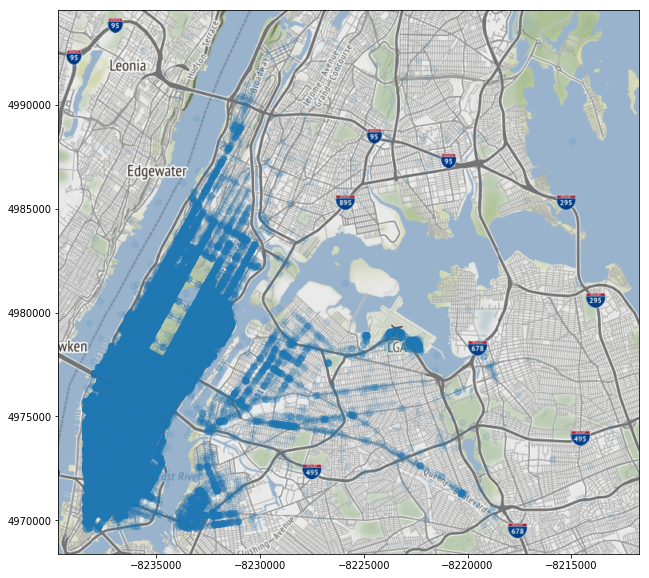

In [9]:
df = taxi_trips_sample.select("pickup_longitude","pickup_latitude") \
    .filter((taxi_trips_sample["pickup_longitude"] >= min_pickup_longitude) & (taxi_trips_sample["pickup_longitude"] <= max_pickup_longitude)) \
    .filter((taxi_trips_sample["pickup_latitude"] >= min_pickup_latitude) & (taxi_trips_sample["pickup_latitude"] <= max_pickup_latitude)) \
    .toPandas()

# Convert DataFrame to GeoDataFrame  
coords = pd.Series(zip(df["pickup_longitude"], df["pickup_latitude"]))
geo_df = gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'}, geometry = coords.apply(Point)).to_crs(epsg=3857)

# ... and make the plot
ax = geo_df.plot(figsize=(15, 10), alpha=0.1)

# Add basemap below
add_basemap(ax, 12)

Retrieve the geo extends for later reuse for more visualizations.

In [10]:
geo_min_x, geo_max_x = ax.get_xlim()
geo_min_y, geo_max_y = ax.get_ylim()

print("geo_min_x=" + str(geo_min_x))
print("geo_max_x=" + str(geo_max_x))
print("geo_min_y=" + str(geo_min_y))
print("geo_max_y=" + str(geo_max_y))

geo_min_x=-8239699.362119416
geo_max_x=-8211764.017450218
geo_min_y=4968388.837210358
geo_max_y=4994559.7578105135


# 3. Data Cleaning

Let us get some basic statistics about the dataset. This will help us to find (and remove) outliers, which probably contain invalid data.

In [11]:
min_max = taxi_trips.select(
        f.min(f.col("trip_distance")),
        f.max(f.col("trip_distance")),
        f.min(f.col("trip_time_in_secs")),
        f.max(f.col("trip_time_in_secs")),
        f.min(f.col("passenger_count")),
        f.max(f.col("passenger_count")),
        f.min(f.col("total_amount")),
        f.max(f.col("total_amount"))
    )

min_max.toPandas()

,min(trip_distance),max(trip_distance),min(trip_time_in_secs),max(trip_time_in_secs),min(total_amount),max(total_amount)
0,0.0,15331800.0,-6480,4294966,-1430.0,685908.1


Let us now analyze the an asymmetric 90% quantile of some metrics, again to get a feeling for a probably trustworthy range. We chose the range to be asymmetric since we do not want to drop very short trips (which may well happen quite often). 

In [19]:
quantiles = taxi_trips.stat.approxQuantile(
        ["trip_distance", "trip_time_in_secs", "total_amount"], 
        [0.01, 0.91], 
        0.01
    )

for q in quantiles:
    print("Quantile: " + str(q))

min_trip_distance = max(0, 0.5*quantiles[0][0])
max_trip_distance = 2*quantiles[0][1]
min_trip_time = max(0, 0.5*quantiles[1][0])
max_trip_time = 2*quantiles[1][1]
min_total_amount = max(0, 0.5*quantiles[2][0])
max_total_amount = 2*quantiles[2][1]

min_passenger_count = 1
max_passenger_count = 10

print("min_trip_distance=" + str(min_trip_distance))
print("max_trip_distance=" + str(max_trip_distance))
print("min_trip_time=" + str(min_trip_time))
print("max_trip_time=" + str(max_trip_time))
print("min_total_amount=" + str(min_total_amount))
print("max_total_amount=" + str(max_total_amount))

Quantile: [0.0, 8.0]
Quantile: [-6480.0, 1512.0]
Quantile: [-1430.0, 35.3]
min_trip_distance=0
max_trip_distance=16.0
min_trip_time=0
max_trip_time=3024.0
min_total_amount=0
max_total_amount=70.6


## 3.2 Clean Data

Now that we have determined meaningful and realistic ranges of the metrics, let us remove all records, which do not comply to these ranges.

In [37]:
cleaned_taxi_trips = taxi_trips.where(
    (f.col("trip_distance") > min_trip_distance) &
    (f.col("trip_distance") < max_trip_distance) &
    (f.col("trip_time_in_secs") > min_trip_time) &
    (f.col("trip_time_in_secs") < max_trip_time) &
    (f.col("total_amount") > min_total_amount) &
    (f.col("total_amount") < max_total_amount) &
    (f.col("passenger_count") >= min_passenger_count) &
    (f.col("passenger_count") <= max_passenger_count))

# 4. Simple Questions

Using the taxi trips table, we can already answer some simple questions.

## 4.1 Average Fare per Mile

Every trip has a distance and a fare. We are now interested in the average fare per mile. That means we first calculate the price per mile for each trip, then calculate the average. The base informationis contained in the columns "total_amunt" and "trip_distance". On top of that we also calculate the standard deviation.

In [40]:
# Calculate average fare per mile in a new column
df = cleaned_taxi_trips.withColumn("fare_per_mile", taxi_trips["total_amount"]/taxi_trips["trip_distance"])

# Now calculate average fare per mile and standard deviation over all trips
result = df.select(
    f.avg(df["fare_per_mile"]).alias("avg_fare_per_mile"),
    f.stddev(df["fare_per_mile"]).alias("stddev_fare_per_mile"),
    f.min(df["fare_per_mile"]).alias("min_fare_per_mile"),
    f.max(df["fare_per_mile"]).alias("max_fare_per_mile"),
)

result.toPandas()

,avg_fare_per_mile,stddev_fare_per_mile,min_fare_per_mile,max_fare_per_mile
0,7.33664,20.411938,0.000633,7050.0


## 4.2 Average fare per minute

Now we ask the same question for the price of every minute. The base informationis contained in the columns "total_amunt" and "trip_time_in_secs".

In [41]:
# Calculate average fare per minute in a new column
df = cleaned_taxi_trips.withColumn("fare_per_minute", taxi_trips["total_amount"]/taxi_trips["trip_time_in_secs"]*60)

# Now calculate average and standard deviation over all trips
result = df.select(
    f.avg(df["fare_per_minute"]).alias("avg_fare_per_minute"),
    f.stddev(df["fare_per_minute"]).alias("stddev_fare_per_minute"),
    f.min(df["fare_per_minute"]).alias("min_fare_per_minute"),
    f.max(df["fare_per_minute"]).alias("max_fare_per_minute"),
)

result.toPandas()

,avg_fare_per_minute,stddev_fare_per_minute,min_fare_per_minute,max_fare_per_minute
0,1.351165,7.831115,0.000199,4230.0


# 5. Make some Pictures

Just to get a rough feeling about the data, we make some pictures of the taxi trip data.

## 5.1 Average trips per day of week

Let us see if the average number of trips is the same for every week day. That means we want to get the average number of trips on mondays, tuesdays, etc...

Text(0.5, 1.0, 'Day of week')

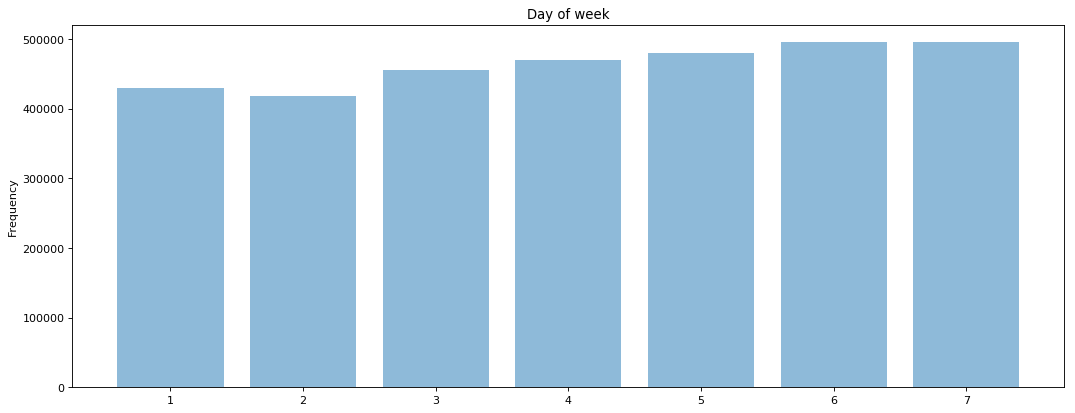

In [24]:
# Step 1: Calculate the number of trips for every day
trips_per_day = cleaned_taxi_trips \
    .withColumn("pickup_date", f.to_date(f.col("pickup_datetime"))) \
    .groupBy("pickup_date") \
    .count()

# Step 2: Calculate average number of trips per day of week
result = trips_per_day \
    .withColumn("pickup_dayofweek", f.dayofweek(f.col("pickup_date"))) \
    .groupBy("pickup_dayofweek").agg(
        f.avg(f.col("count")).alias("avg_count")
    )

pdf = result.toPandas()

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(pdf["pickup_dayofweek"], pdf["avg_count"], align='center', alpha=0.5)
plt.ylabel('Frequency')
plt.title('Day of week')

## 5.2 Make a Plot of Fare per Day

The next picture contains the total fare amount (including tip and other expenses) for every day in 2013.

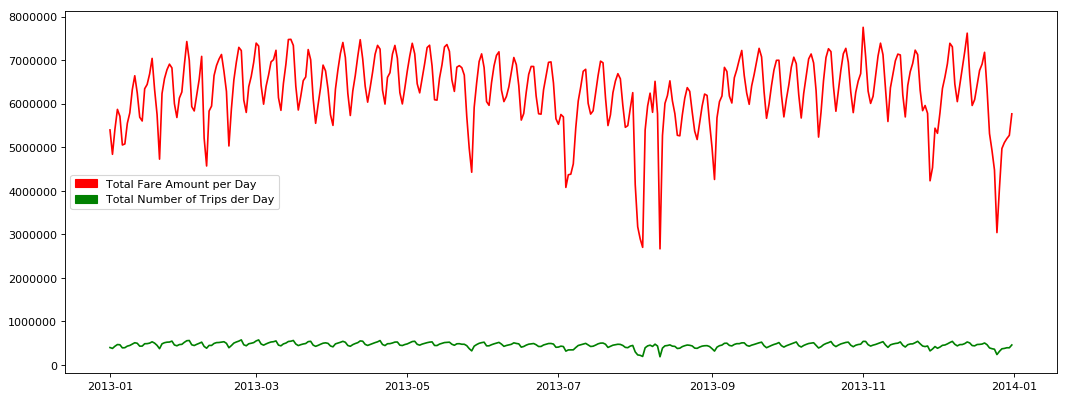

In [25]:
daily = cleaned_taxi_trips \
    .withColumn("date", f.to_date('pickup_datetime')) \
    .groupBy("date").agg(
        f.sum("total_amount").alias("amount"),
        f.count("total_amount").alias("count")
    )\
    .orderBy("date")

# Convert to Pandas    
pdf = daily.toPandas()

# Make a Plot
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pdf["date"],pdf["amount"], color="red")
plt.plot(pdf["date"],pdf["count"], color="green")

plt.legend(handles=[
    mpatches.Patch(color='red', label='Total Fare Amount per Day'),
    mpatches.Patch(color='green', label='Total Number of Trips der Day')
])

## 5.3 Make a plot of average trips for each hour

Let us plot the average number of trips and amount of income per hour. This will be done using a two step aggregation:
1. Calculate the total number of trips and total fare for every hour in the whole year
2. Calculate the average numbers per hour from this data

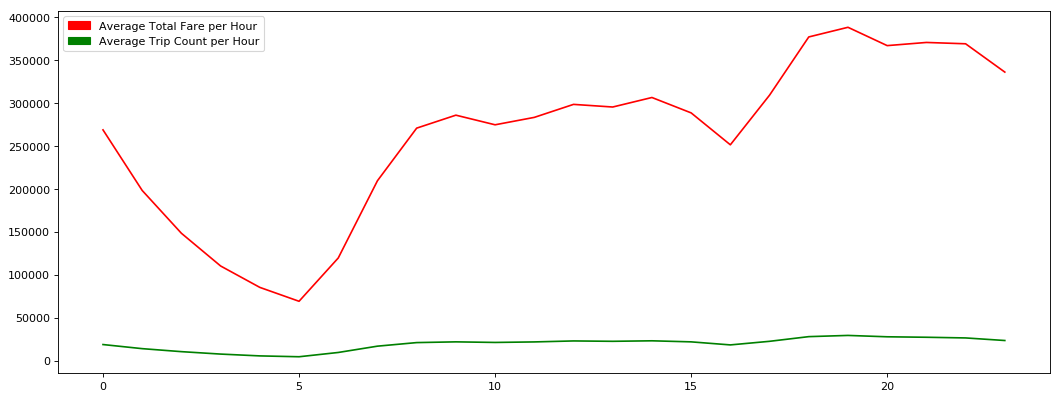

In [26]:
hourly_avg = cleaned_taxi_trips \
    .withColumn("date", f.to_date('pickup_datetime')) \
    .withColumn("hour", f.hour('pickup_datetime')) \
    .groupBy("hour", "date").agg(
        f.sum("total_amount").alias("total_amount"),
        f.count("total_amount").alias("total_count")
    )\
    .groupBy("hour").agg(
        f.avg("total_amount").alias("avg_amount"),
        f.avg("total_count").alias("avg_count")
    )\
    .orderBy("hour")

# Convert to Pandas    
pdf = hourly_avg.toPandas()

# Make a Plot
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pdf["hour"],pdf["avg_amount"], color="red")
plt.plot(pdf["hour"],pdf["avg_count"], color="green")

plt.legend(handles=[
    mpatches.Patch(color='red', label='Average Total Fare per Hour'),
    mpatches.Patch(color='green', label='Average Trip Count per Hour')
])

## 5.4 Passenger Counts

Another simple question is a histogram of the passenger count of all trips. Note that again the data contains some bogus data, therefore we limit the analysis to records with a passenger count less than 20.

Text(0.5, 1.0, 'Number of Passengers')

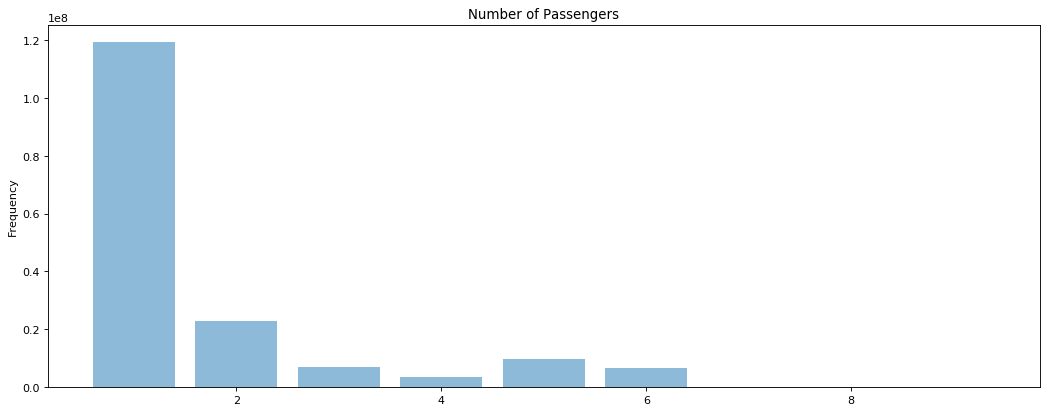

In [33]:
result = cleaned_taxi_trips \
    .groupBy("passenger_count") \
    .count()
pdf = result.toPandas()

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(pdf["passenger_count"], pdf["count"], align='center', alpha=0.5)
plt.ylabel('Frequency')
plt.title('Number of Passengers')

## 5.5 Average income by hour by driver

The next plot is a slight variation of the previous one, focusing on the individual driver. The question is, how much money does a driver make on average for a specific hour of the day. Again, this requires a two step aggregation

1. Calculate the total amount for every hour of the year for each driver
2. Calculate the average income per hour over all days and all drivers

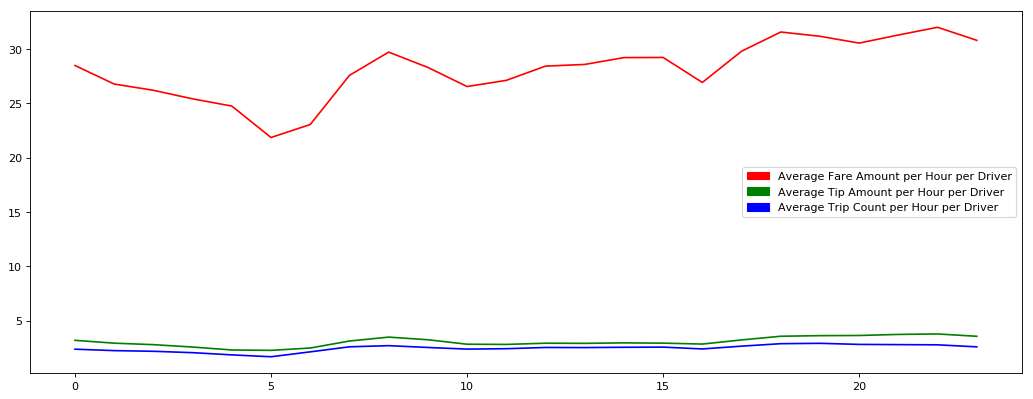

In [28]:
hourly_driver_avg = cleaned_taxi_trips \
    .withColumn("date", f.to_date('pickup_datetime')) \
    .withColumn("hour", f.hour('pickup_datetime')) \
    .groupBy("date", "hour", "hack_license").agg(
        f.sum("fare_amount").alias("fare_amount"),
        f.sum("tip_amount").alias("tip_amount"),
        f.count("fare_amount").alias("trip_count")
    ) \
    .groupBy("hour").agg(
        f.avg("fare_amount").alias("avg_fare_amount"),
        f.avg("tip_amount").alias("avg_tip_amount"),
        f.avg("trip_count").alias("avg_trip_count")
    ) \
    .orderBy("hour")

# Convert to Pandas    
pdf = hourly_driver_avg.toPandas()

# Make a Plot
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pdf["hour"],pdf["avg_fare_amount"], color="red")
plt.plot(pdf["hour"],pdf["avg_tip_amount"], color="green")
plt.plot(pdf["hour"],pdf["avg_trip_count"], color="blue")

plt.legend(handles=[
    mpatches.Patch(color='red', label='Average Fare Amount per Hour per Driver'),
    mpatches.Patch(color='green', label='Average Tip Amount per Hour per Driver'),
    mpatches.Patch(color='blue', label='Average Trip Count per Hour per Driver')
])

## 5.6 Average income per day

The next plot is a slight variation of the previous one, now looking at the income on a whole day. The question is, how much money does a driver make on average for a specific day. Again, this requires a two step aggregation

1. Calculate the total amount for every day of the year for each driver
2. Calculate the average income per day over all days and all drivers

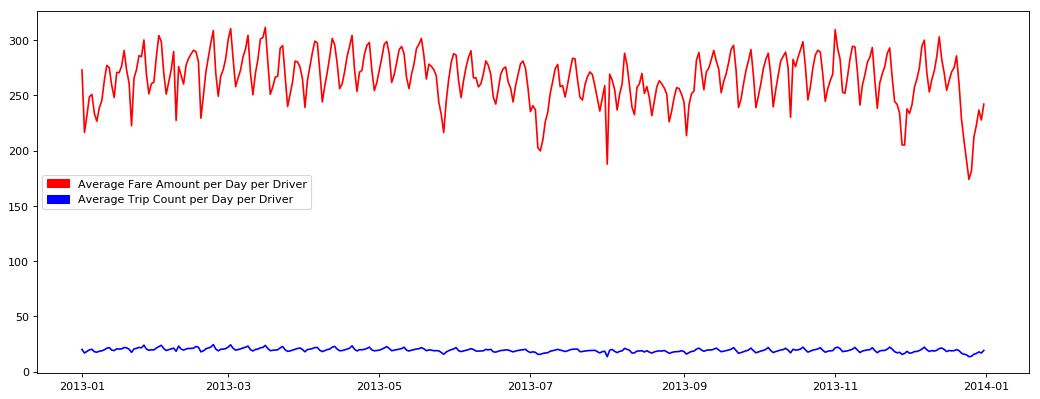

In [29]:
hourly_driver_avg = cleaned_taxi_trips \
    .withColumn("date", f.to_date('pickup_datetime')) \
    .groupBy("date", "hack_license").agg(
        f.sum("total_amount").alias("amount"),
        f.count("total_amount").alias("count")
    ) \
    .groupBy("date").agg(
        f.avg("amount").alias("avg_amount"),
        f.avg("count").alias("avg_count")
    ) \
    .orderBy("date")

# Convert to Pandas    
pdf = hourly_driver_avg.toPandas()

# Make a Plot
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pdf["date"],pdf["avg_amount"], color="red")
plt.plot(pdf["date"],pdf["avg_count"], color="blue")

plt.legend(handles=[
    mpatches.Patch(color='red', label='Average Fare Amount per Day per Driver'),
    mpatches.Patch(color='blue', label='Average Trip Count per Day per Driver')
])

## 5.7 Tip by passenger count

Does the tip depend on the number of passengers? Let us display the average tip amount for each number of passengers.

Text(0.5, 1.0, 'Number of Passengers')

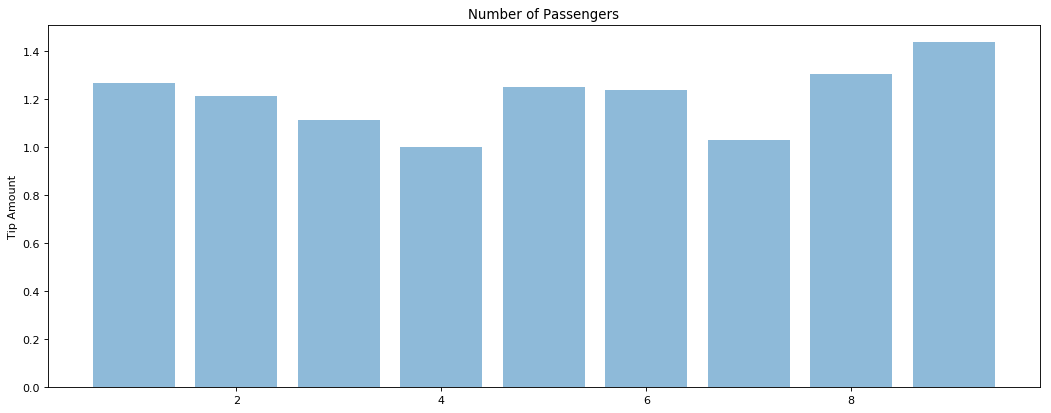

In [32]:
tip_by_passengers = cleaned_taxi_trips \
    .groupBy("passenger_count").agg(
        f.avg("tip_amount").alias("tip_amount")
    ) \
    .orderBy("passenger_count")

# Convert to Pandas    
pdf = tip_by_passengers.toPandas()

# Make a Plot
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(pdf["passenger_count"], pdf["tip_amount"], align='center', alpha=0.5)
plt.ylabel('Tip Amount')
plt.title('Number of Passengers')

# 6. Preaggregated Taxi Trips

Before we start to include additional data sets from other sources, let us first focus a reasonable question which we'd like to give an answer to with machine learning.

We are not so much interested into the individual trips, but we'd like to understand at which time a driver can make most money. We already saw in the pictures above, that the average amount of money per hour per driver doesn't vary very much, although most money seems to be made in the evening hours. Unfortunately these numbers do not neccessarily tell the whole truth, since we don't have any information about how long a driver was actually working.

So the question is: *"Can we predict the overall fares for a specific hour on a specific day?"* We will refine that question a little bit and clarify what information may be used to create the prediction, such that it makes sense from a business point of view.

We now prepare the joined trip data to contain data for precisely this question - we will remove the drivers hack license and medallion.

## 6.1 Extend Information

As a first step, we add some more columns:
* **date** and **hour** - The pickup date and hour (without minutes or seconds)
* **lat_idx** and **long_idx** - We map the whole geo range into a grid and these two columns contains logical coordinates in this grid.

In [34]:
min_pickup_longitude=-74.007698
max_pickup_longitude=-73.776711
min_pickup_latitude=40.706902
max_pickup_latitude=40.799072

longitude_grid_size = 10
latitude_grid_size = 5
longitude_grid_diff = (max_pickup_longitude - min_pickup_longitude) / longitude_grid_size
latitude_grid_diff = (max_pickup_latitude - min_pickup_latitude) / latitude_grid_size

In [35]:
extended_trips = cleaned_taxi_trips \
    .withColumn("date", f.to_date(taxi_trips["pickup_datetime"])) \
    .withColumn("hour", f.hour(taxi_trips["pickup_datetime"])) \
    .withColumn("lat_idx", f.rint((taxi_trips["pickup_latitude"] - min_pickup_latitude)/latitude_grid_diff)) \
    .withColumn("long_idx", f.rint((taxi_trips["pickup_longitude"] - min_pickup_longitude)/longitude_grid_diff)) \
    .withColumn("lat_idx", f.when((f.col("lat_idx") >= 0) & (f.col("lat_idx") < latitude_grid_size), f.col("lat_idx")).otherwise(-1).cast("int")) \
    .withColumn("long_idx", f.when((f.col("long_idx") >= 0) & (f.col("long_idx") < longitude_grid_size), f.col("long_idx")).otherwise(-1).cast("int")) \

extended_trips.limit(10).toPandas()

,medallion,hack_license,vendor_id,pickup_datetime,rate_code,store_and_fwd_flag,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,date,hour,lat_idx,long_idx
0,00005007A9F30E289E760362F69E4EAD,0938A8DBC34197F8F91F700E3015A7A2,CMT,2013-07-16 09:21:09,1,N,2013-07-16 09:30:51,1,582,1.6,...,8.5,0.0,0.5,3.00,0.00,12.00,2013-07-16,9,4,2
1,00005007A9F30E289E760362F69E4EAD,0FD461760B482C0B229B3E98A2914819,CMT,2013-10-27 23:40:08,1,N,2013-10-27 23:44:37,2,268,1.1,...,5.5,0.5,0.5,1.30,0.00,7.80,2013-10-27,23,2,1
2,00005007A9F30E289E760362F69E4EAD,16780B3E72BAA7A5C152C197919DCA0E,CMT,2013-07-16 19:55:27,1,N,2013-07-16 20:17:49,1,1341,5.6,...,19.5,1.0,0.5,4.20,0.00,25.20,2013-07-16,19,3,1
3,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-10-08 08:37:48,1,N,2013-10-08 08:51:42,2,833,1.9,...,11.0,0.0,0.5,3.00,0.00,14.50,2013-10-08,8,4,1
4,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-10-18 13:49:19,1,N,2013-10-18 14:15:40,1,1580,3.1,...,18.0,0.0,0.5,0.00,0.00,18.50,2013-10-18,13,2,1
5,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-10-28 13:39:04,1,N,2013-10-28 13:58:48,1,1184,1.8,...,13.5,0.0,0.5,2.80,0.00,16.80,2013-10-28,13,3,1
6,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-10-30 08:27:05,1,N,2013-10-30 08:37:00,2,595,1.5,...,8.5,0.0,0.5,0.00,0.00,9.00,2013-10-30,8,3,1
7,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-11-06 07:42:33,1,N,2013-11-06 07:57:27,1,893,3.9,...,14.0,0.0,0.5,2.90,0.00,17.40,2013-11-06,7,3,1
8,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-11-15 11:41:42,1,N,2013-11-15 11:49:49,1,487,1.2,...,7.5,0.0,0.5,0.00,0.00,8.00,2013-11-15,11,3,1
9,00005007A9F30E289E760362F69E4EAD,24C122A944FB8EE21D570C7067400D6F,CMT,2013-12-09 06:22:15,1,N,2013-12-09 06:39:43,1,1048,8.4,...,24.5,0.0,0.5,6.06,5.33,36.39,2013-12-09,6,2,1


## 6.2 Preaggregate and Store into Refined Zone

Now we preaggregate the extended data using the following dimensions
* **date** and **hour**
* **lat_idx** and **long_idx**

In addition to the dimensions, the result will aggregate (sum up) the following metrics
* **passenger_count**
* **fare_amount**
* **tip_amount**
* **total_amount**

In [31]:
hourly_taxi_trips = extended_trips \
    .groupBy("date", "hour", "lat_idx", "long_idx").agg(
        f.count(taxi_trips["fare_amount"]).alias("trip_count"),
        f.sum(taxi_trips["passenger_count"]).alias("passenger_count"),
        f.sum(taxi_trips["fare_amount"]).alias("fare_amount"),
        f.sum(taxi_trips["tip_amount"]).alias("tip_amount"),
        f.sum(taxi_trips["total_amount"]).alias("total_amount")
    )

hourly_taxi_trips.write.format("parquet").mode("overwrite").saveAsTable("refined.taxi_trips_hourly")

In [32]:
hourly_taxi_trips = spark.read.table("refined.taxi_trips_hourly")
hourly_taxi_trips.limit(10).toPandas()

,date,hour,lat_idx,long_idx,trip_count,passenger_count,fare_amount,tip_amount,total_amount
0,2013-04-20,1,2,2,167,287,2229.00,238.87,2658.49
1,2013-11-22,8,0,0,1057,1733,15393.50,2058.23,18044.45
2,2013-04-04,19,4,2,2501,4163,24675.30,2717.09,31245.89
3,2013-04-26,10,2,0,1275,1966,13679.00,1713.01,16174.54
4,2013-03-02,19,-1,-1,843,1484,20441.05,1781.45,23449.38
5,2013-07-21,5,2,1,833,1414,11511.00,987.53,13693.19
6,2013-04-30,10,0,0,718,1279,10563.00,1312.27,12297.74
7,2013-11-01,11,3,0,614,1128,9042.00,661.95,10082.30
8,2013-03-31,13,3,1,3535,6627,42382.80,3048.82,48261.72
9,2013-11-17,21,2,0,1148,1977,12083.00,1395.63,14684.69


# 7. More Pictures

Using the preaggregated data set, we can now draw some more pictures.

## 7.1 Daily Aggregates

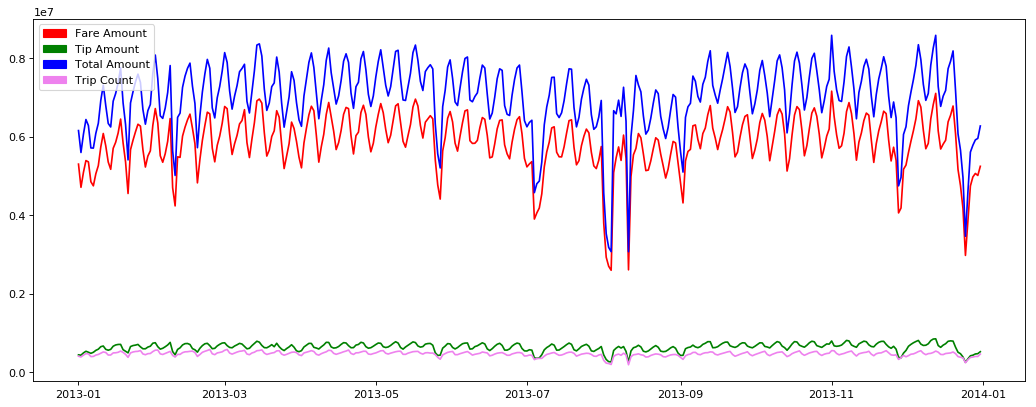

In [33]:
daily = hourly_taxi_trips \
    .groupBy("date").agg(
        f.sum("fare_amount").alias("fare_amount"),
        f.sum("tip_amount").alias("tip_amount"),
        f.sum("total_amount").alias("total_amount"),
        f.sum("trip_count").alias("trip_count")
    )\
    .orderBy("date")

# Convert to Pandas    
pdf = daily.toPandas()

# Make a Plot
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pdf["date"],pdf["fare_amount"], color="red")
plt.plot(pdf["date"],pdf["tip_amount"], color="green")
plt.plot(pdf["date"],pdf["total_amount"], color="blue")
plt.plot(pdf["date"],pdf["trip_count"], color="violet")

plt.legend(handles=[
    mpatches.Patch(color='red', label='Fare Amount'),
    mpatches.Patch(color='green', label='Tip Amount'),
    mpatches.Patch(color='blue', label='Total Amount'),
    mpatches.Patch(color='violet', label='Trip Count')
])

## 7.2 Average fare and tip per hour

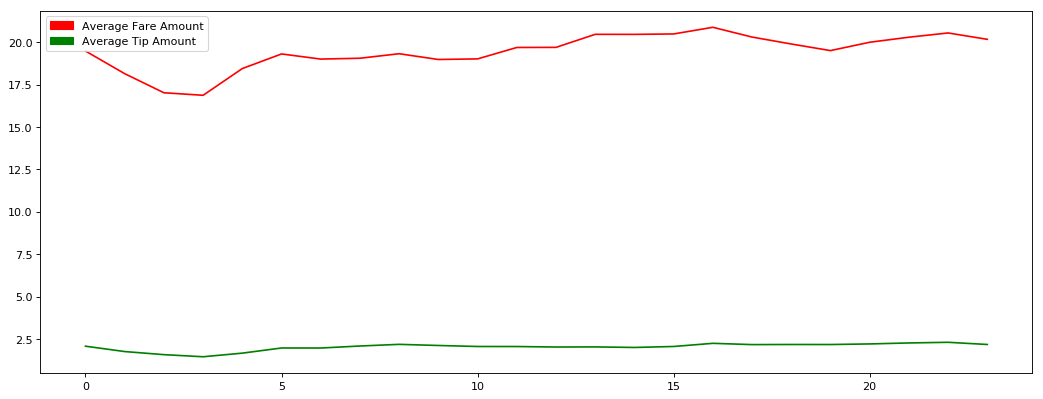

In [34]:
hourly = hourly_taxi_trips \
    .groupBy("hour").agg(
        f.avg(hourly_taxi_trips["fare_amount"] / hourly_taxi_trips["trip_count"]).alias("avg_fare_amount"),
        f.avg(hourly_taxi_trips["tip_amount"] / hourly_taxi_trips["trip_count"]).alias("avg_tip_amount")
    )\
    .orderBy("hour")

# Convert to Pandas    
pdf = hourly.toPandas()

# Make a Plot
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pdf["hour"],pdf["avg_fare_amount"], color="red")
plt.plot(pdf["hour"],pdf["avg_tip_amount"], color="green")

plt.legend(handles=[
    mpatches.Patch(color='red', label='Average Fare Amount'),
    mpatches.Patch(color='green', label='Average Tip Amount')
])